In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
from tqdm.notebook import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [21]:
with open(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample_big__compare_output.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)
# NOTE TLE represented is probably not what you expect (but i dont have time to fix yet)
# ground truth -> X (NOT ground truth TLE)
# baseline -> X
# pred -> predicted Y

In [36]:
def compare(s1,s2):
    s = np.sqrt(((data_dict[s2][['SAT_RX','SAT_RY','SAT_RZ']] - data_dict[s1][['SAT_RX','SAT_RY','SAT_RZ']])**2).sum(axis=1))
    s.name = f'{s2}_error'
    return s


base_error = compare('tle_ground_truth','sgp4_baseline')

pred_error = compare('tle_ground_truth','model_t5_predictions')
compare_df = data_dict['sgp4_baseline'][['EPOCH_DIFF']].merge(base_error, left_index=True, right_index=True)
compare_df = compare_df.merge(pred_error, left_index=True, right_index=True)

print("baseline error")
display(base_error.describe())
print("model error")
display(pred_error.describe())
print("compare")
display(compare_df)


baseline error


count    3.422012000000e+06
mean     2.149944946173e+03
std      2.396498559350e+03
min      1.322501605846e-01
25%      8.095359492927e+02
50%      1.354071383307e+03
75%      2.596687113607e+03
max      1.596694659946e+04
Name: sgp4_baseline_error, dtype: float64

model error


count    3.422012000000e+06
mean     3.964576124083e+02
std      8.835230217252e+02
min      3.103382344091e-01
25%      1.522276787813e+02
50%      2.625774206144e+02
75%      3.922282763007e+02
max      1.786811630468e+04
Name: model_t5_predictions_error, dtype: float64

compare


,EPOCH_DIFF,sgp4_baseline_error,model_t5_predictions_error
0,2.307414610000,713.836254378552,329.411551809407
1,3.028445960000,937.078256426128,264.542205180228
2,2.018816670000,625.122461042644,301.629256107941
3,3.388695700000,1049.431296104838,250.522550430523
4,2.235077099988,691.638136321957,341.119001887293
...,...,...,...
3422007,12.024337480000,1450.284466481911,101.072183587836
3422008,12.767355500000,1539.560354119430,138.787330819609
3422009,12.767326070000,1539.543440939285,139.598648897347
3422010,12.429543600000,1498.973198369315,122.369690543685


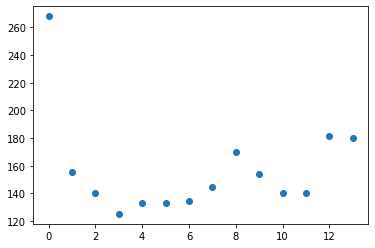

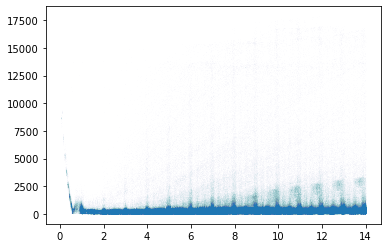

In [93]:
top_half_model = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_t5_predictions_error.nsmallest(len(x)//2)))
plt.scatter(top_half_model.index, top_half_model)
plt.show()
plt.scatter(compare_df.EPOCH_DIFF, compare_df.model_t5_predictions_error, s=0.001, alpha = 0.1)
plt.show()

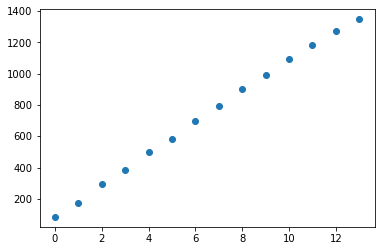

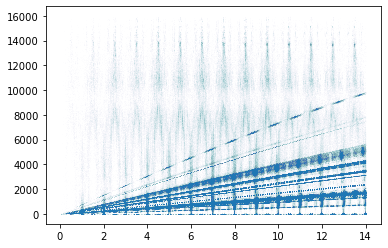

In [94]:
top_half_baseline = compare_df.groupby('bin').apply(lambda x:np.mean(x.sgp4_baseline_error.nsmallest(len(x)//2)))
plt.scatter(top_half_baseline.index, top_half_baseline)
plt.show()
plt.scatter(compare_df.EPOCH_DIFF, compare_df.sgp4_baseline_error, s=0.001, alpha = 0.1)
plt.show()

In [78]:
one_day_or_less = compare_df[(compare_df.EPOCH_DIFF < 1)]
print((one_day_or_less.sgp4_baseline_error > one_day_or_less.model_t5_predictions_error).value_counts())
print(((compare_df.EPOCH_DIFF > 0.5) & (compare_df.sgp4_baseline_error > compare_df.model_t5_predictions_error)).value_counts())

False    18867
True      4290
dtype: int64
True     3118308
False     303704
dtype: int64


bin
0     0.185257157663
1     0.636516016121
2     0.860262257291
3     0.914320954280
4     0.926046917450
5     0.915834164068
6     0.920423459488
7     0.914829782023
8     0.927413193455
9     0.926212770654
10    0.935353094605
11    0.935369893265
12    0.935902546240
13    0.932175842215
dtype: float64

<AxesSubplot:xlabel='bin'>

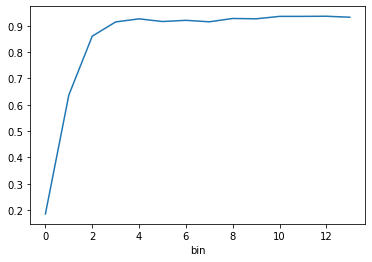

In [80]:
compare_df['bin'] = compare_df['EPOCH_DIFF'].astype(int)
compare_df['model_better'] = (compare_df.sgp4_baseline_error > compare_df.model_t5_predictions_error)
better_against_epoch_diff = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_better))
display(better_against_epoch_diff)
better_against_epoch_diff.plot()